# Color nonlinearities

The idea is to generate a gradient of colors which are linearly spaced in the ATD color spaces (oponent color channels) and then check if the response of a model is linear or not (it shouldn't be).

## Importing libraries

In [1]:
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from perceptualtests.receptive_fields import *

## Define a `tf.data.Dataset` from the deltas generator

In [2]:
img_height, img_width, channels, fov = 384, 512, 3, 32

In [ ]:
deltas_dataset = tf.data.Dataset.from_generator(obtain_receptive_field_gen, 
                                                args=(img_height,img_width,channels,fov),
                                                output_signature=(
                                                    tf.TensorSpec(shape=(img_height,img_width,channels), dtype=tf.float32)
                                                    )
                                                )

## Passing the deltas through the network

As an example we'll use a fake model that we can override at any time:

In [4]:
class FakeNetwork():
    def __call__(self, X):
        return X
    def predict(self, X):
        return self(X)

In [5]:
model = FakeNetwork()

### Keeping only one channel

In [6]:
%%time
channel_to_keep = 0
batch_size = 10

responses = np.empty(shape=(fov*2)*(fov*2)*channels)
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,channel_to_keep]

2022-04-27 15:48:16.000438: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


  0%|          | 0/1228 [00:00<?, ?it/s]

CPU times: user 43.7 s, sys: 2.45 s, total: 46.2 s
Wall time: 44.4 s


In [7]:
responses2 = responses.reshape((fov*2, fov*2, channels))
rf = (responses2 - responses2.min()) / (responses2.max() - responses2.min())
rf.shape

(64, 64, 3)

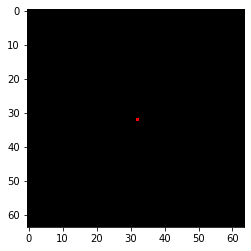

In [8]:
plt.imshow(rf)
plt.show()

### Keeping all the channels

In [9]:
%%time
batch_size = 16
output_channels = 3

responses = np.empty(shape=((fov*2)*(fov*2)*channels, output_channels))
for i, delta in tqdm(enumerate(deltas_dataset.batch(batch_size)), total=fov*2*fov*2*channels//batch_size):
    response = model.predict(delta)
    ## Now we keep only the center response of a specific channel
    response_height, response_width = response.shape[1:3] # [BatchDim, H, W, C]
    responses[i*batch_size:i*batch_size+batch_size] = response[:,response_height//2,response_width//2,:]

  0%|          | 0/768 [00:00<?, ?it/s]

CPU times: user 42.8 s, sys: 5.81 s, total: 48.6 s
Wall time: 46.8 s


In [10]:
responses.shape, response.shape

((12288, 3), TensorShape([16, 384, 512, 3]))

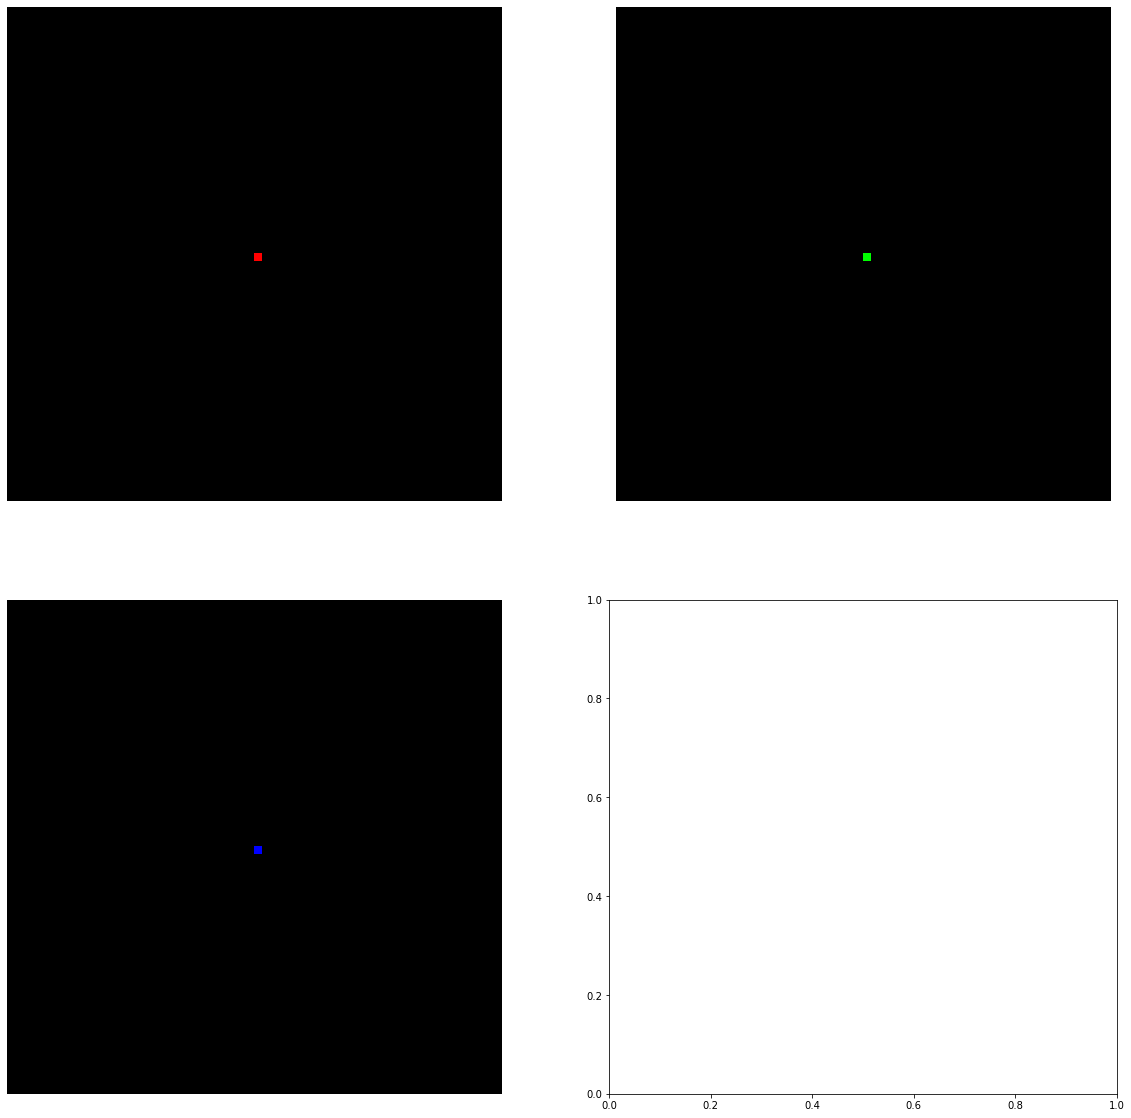

In [11]:
nrows, ncols = [int(np.ceil(np.sqrt(output_channels)))]*2
fig, ax = plt.subplots(nrows, ncols, figsize=(20,20))
ax = ax.ravel()
for ch in range(output_channels):
    ch_response = responses[:,ch]
    ch_response = ch_response.reshape((fov*2, fov*2, channels))
    ch_response = (ch_response - ch_response.min()) / (ch_response.max() - ch_response.min())
    ax[ch].imshow(ch_response)
    ax[ch].axis('off')
    # break
plt.show()